In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Masking 
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"


%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_pt', 'wl_eta', 'wl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']


Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'carteta', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'boxcox', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 1.7053025658242404e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(80000, 6, 5) (80000, 6) (80000, 9)
(20000, 6, 5) (20000, 6) (20000, 9)


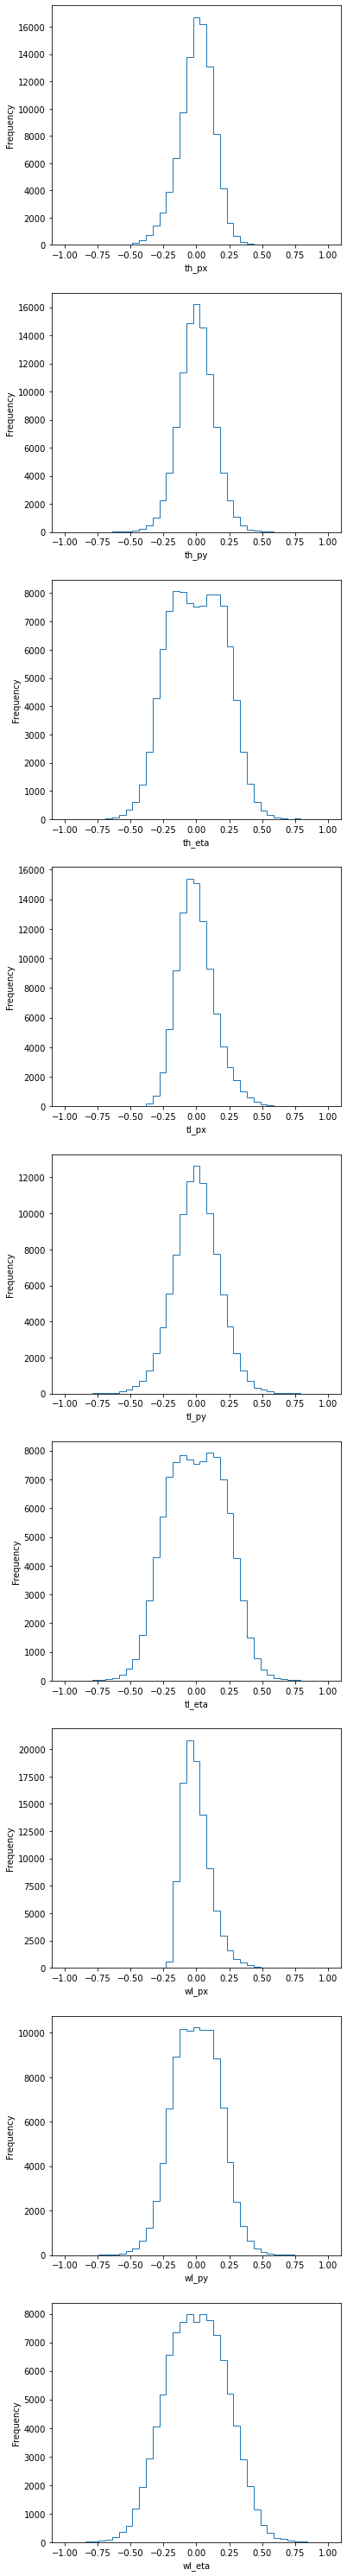

In [4]:
# Histograms of total  Y variables 
show = True

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Conv11 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=initializers.he_uniform())(Mask)
    Conv12 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer=initializers.he_uniform())(Conv11)
    flat_jets = Flatten()(Conv11)
    
    other_input = Input(shape=(trainX_other.shape[1]))
    Dense21 = Dense(64, activation='relu')(other_input)
    Dense22 = Dense(32, activation='relu')(Dense21)
    flat_other = Flatten()(Dense21)
    
    concat = concatenate([flat_other, flat_jets])
    dense1 = Dense(256, activation='relu')(concat)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(len(Y_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=1e-6)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 5)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 6, 5)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           448         input_2[0][0]                    
______________________________________________________________________________________________

In [7]:
# Fit model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Epochs= 2048

del X_total
del Y_total

history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)

Train on 64000 samples, validate on 16000 samples
Epoch 1/2048
64000/64000 [==============================] - 3s 45us/sample - loss: 0.0568 - mse: 0.0568 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 2/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0504 - val_mse: 0.0504
Epoch 3/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0475 - val_mse: 0.0475
Epoch 4/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0468 - mse: 0.0468 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 5/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0430 - val_mse: 0.0430
Epoch 6/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0412 - val_mse: 0.0412
Epoch 7/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0410 - mse: 0.0410 

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 59/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 60/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 61/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 62/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 63/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 64/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 65/2048
64000/6

Epoch 116/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 117/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 118/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 119/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 120/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 121/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 122/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0162 - val_mse: 0.0162
Epo

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 174/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 175/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 176/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 177/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 178/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 179/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 180/2048
640

Epoch 231/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 232/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 233/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 234/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 235/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 236/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 237/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0129 - val_mse: 0.0129
Epoch

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 289/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 290/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 291/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 292/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 293/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 294/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 295/2048
6

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 346/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 347/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 348/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 349/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 350/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 351/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 352/2048
64000

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 403/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 404/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 405/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 406/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 407/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 408/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 409/2048
64

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 460/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 461/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 462/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 463/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 464/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 465/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 466/2048
64

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 517/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 518/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 519/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 520/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 521/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 522/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 523/2048
64

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 574/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 575/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 576/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 577/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 578/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 579/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 580/2048
6

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 631/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 632/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 633/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 634/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 635/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 636/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 637/2048


64000/64000 [==============================] - 1s 9us/sample - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 688/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 689/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 690/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 691/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 692/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 693/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 694/2048
64000

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 745/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 746/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 747/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 748/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 749/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 750/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 751/2048
64

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 802/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 803/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 804/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 805/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 806/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 807/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 808/2048
640

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 859/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 860/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 861/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 862/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 863/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 864/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 865/2048
6

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 916/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 917/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 918/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 919/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 920/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 921/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 922/2048
64

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 973/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 974/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 975/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 976/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 977/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 978/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 979/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 1030/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 1031/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 1032/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 1033/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 1034/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 1035/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 1036/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 1087/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 1088/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 1089/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 1090/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 1091/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 1092/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 1093/2

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 1144/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 1145/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1146/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1147/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1148/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1149/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 115

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1201/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1202/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1203/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1204/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1205/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1206/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 1207

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 1258/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 1259/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 1260/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 1261/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 1262/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 1263/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 1264/

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1315/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1316/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1317/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1318/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1319/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1320/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 132

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1372/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1373/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1374/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1375/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1376/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1377/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 1378/

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 1429/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 1430/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 1431/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 1432/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 1433/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 1434/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 1435

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1486/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1487/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1488/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1489/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1490/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1491/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1492

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1543/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1544/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1545/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1546/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1547/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1548/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 1549/20

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1600/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1601/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1602/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1603/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1604/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1605/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 160

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1657/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1658/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1659/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1660/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1661/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 1662/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 16

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1714/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1715/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1716/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1717/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1718/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1719/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1720/2

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1771/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1772/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1773/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1774/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1775/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1776/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 1777/

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1828/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1829/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1830/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1831/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1832/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1833/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 18

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1885/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1886/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1887/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1888/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1889/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1890/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 18

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1942/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1943/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1944/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1945/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1946/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1947/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 1948

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 1999/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2000/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2001/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2002/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2003/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2004/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 2005/2

Text(0.5, 1.0, 'MSE loss')

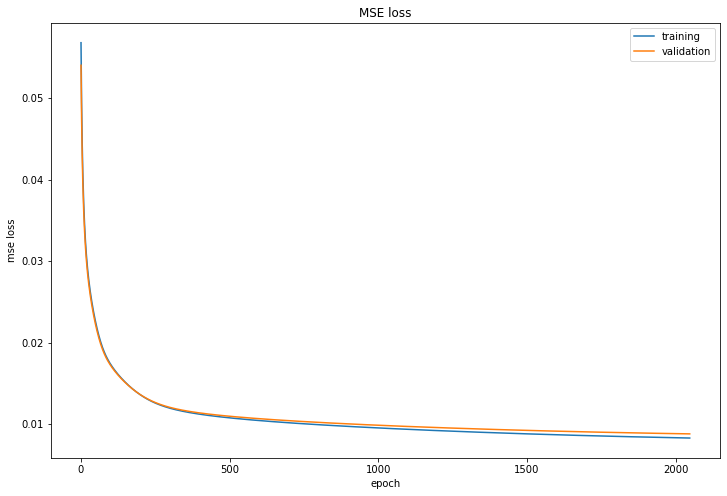

In [8]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [9]:
class Analysis:
    def __init__(self):
        self.crop = 100
        self.fsize = 6
        self.histogram_bins = 40
        
    def wrap_phi(self, var):
        var = var%(2*np.pi)
        var = var - 2*np.pi*(var > np.pi)
        return var
        
    def predictions_vs_sample(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2, self.fsize*len(names)))
        for i in range(0, len(names)):
            compare_small = compare[:self.crop,i]
            true_small = true[:self.crop,i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            plt.subplot(len(names), 1, i+1)
            plt.plot(range(0,self.crop), compare_small, 'bo', markersize=3, label = 'Predictions')
            plt.plot(range(0,self.crop), true_small, 'ro', markersize=3, label = 'True Value')
            ym, yM = plt.ylim()
            for x in range(self.crop):
                plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                            min(compare_small[x], true_small[x]), 
                            ymax= max(compare_small[x], true_small[x]))
            plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=self.crop+20, alpha=0.5)
            MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
            plt.xlabel('Sample')
            plt.xlim(0, self.crop)
            plt.ylabel(names[i])
            plt.title(names[i] + " MSE: " + str(MSE))
            plt.legend()
    
    def display_errors(self, compare, true, names, wrap_phi):
        MSE = 1/compare.size*np.sum((compare- true)**2)
        print("total MSE: " + str(MSE))
        print(" ")
        for i in range(len(names)):
            diff = compare[:,i] -true[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            MSE = 1/compare[:,i].size*np.sum((diff)**2)
            print("{0} MSE : ".format(names[i]), '%.10f'%MSE)
    
    def difference_histogram(self, compare, true, names, wrap_phi, bins):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            diff = true[:,i] - compare[:,i]
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
            plt.hist(diff, hbins, histtype='step', color='purple', label='true - predicted', density=True)
            plt.xlabel("Difference (Mean: {0}, Std: {1})".format(np.mean(diff), np.std(diff)))
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
            
    def variable_histogram(self, compare, true, names, wrap_phi, bins): 
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            compare_small = compare[:, i]
            true_small = true[:, i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
                
            plt.hist(true_small, hbins, histtype='step', color='b', label='true values', density=False)
            plt.hist(compare_small, hbins, histtype='step', color='r', label='predictions', density=False)
            plt.xlabel(names[i])
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
    
    def difference_vs_variable(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], true[:, i]-compare[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
            plt.xlabel('True ' + names[i])
            plt.legend()
            plt.ylabel('Difference')
    
    def predicted_vs_true(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], compare[:, i], 'o', color='g', markersize=2)
            line = np.linspace(np.min(true[:, i]), np.max(true[:, i]), 100)
            plt.plot(line, line, color='b')
            plt.xlabel('True')
            plt.title(names[i])
            plt.ylabel('Predicted')

In [10]:
display = Analysis()

predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

# Training scale plots 

In [11]:
display.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.008761887428891214
 
th_px MSE :  0.0074493457
th_py MSE :  0.0101663121
th_eta MSE :  0.0115733529
tl_px MSE :  0.0057893674
tl_py MSE :  0.0134491063
tl_eta MSE :  0.0098567558
wl_px MSE :  0.0021305771
wl_py MSE :  0.0091350511
wl_eta MSE :  0.0093071184


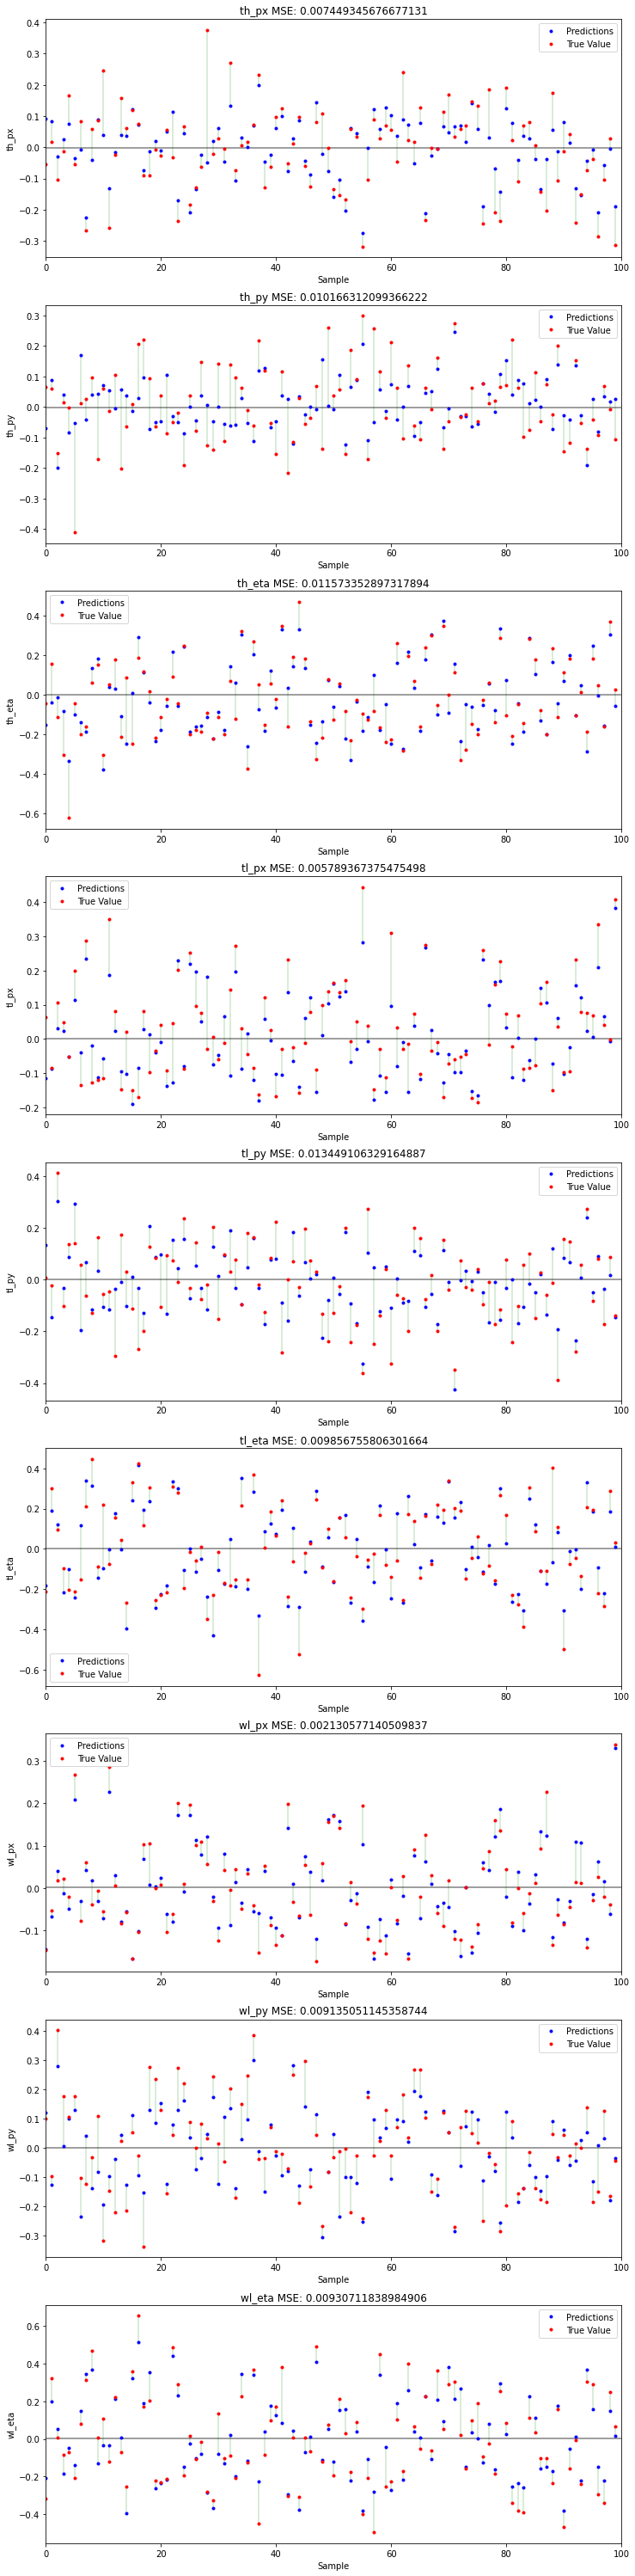

In [12]:
display.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

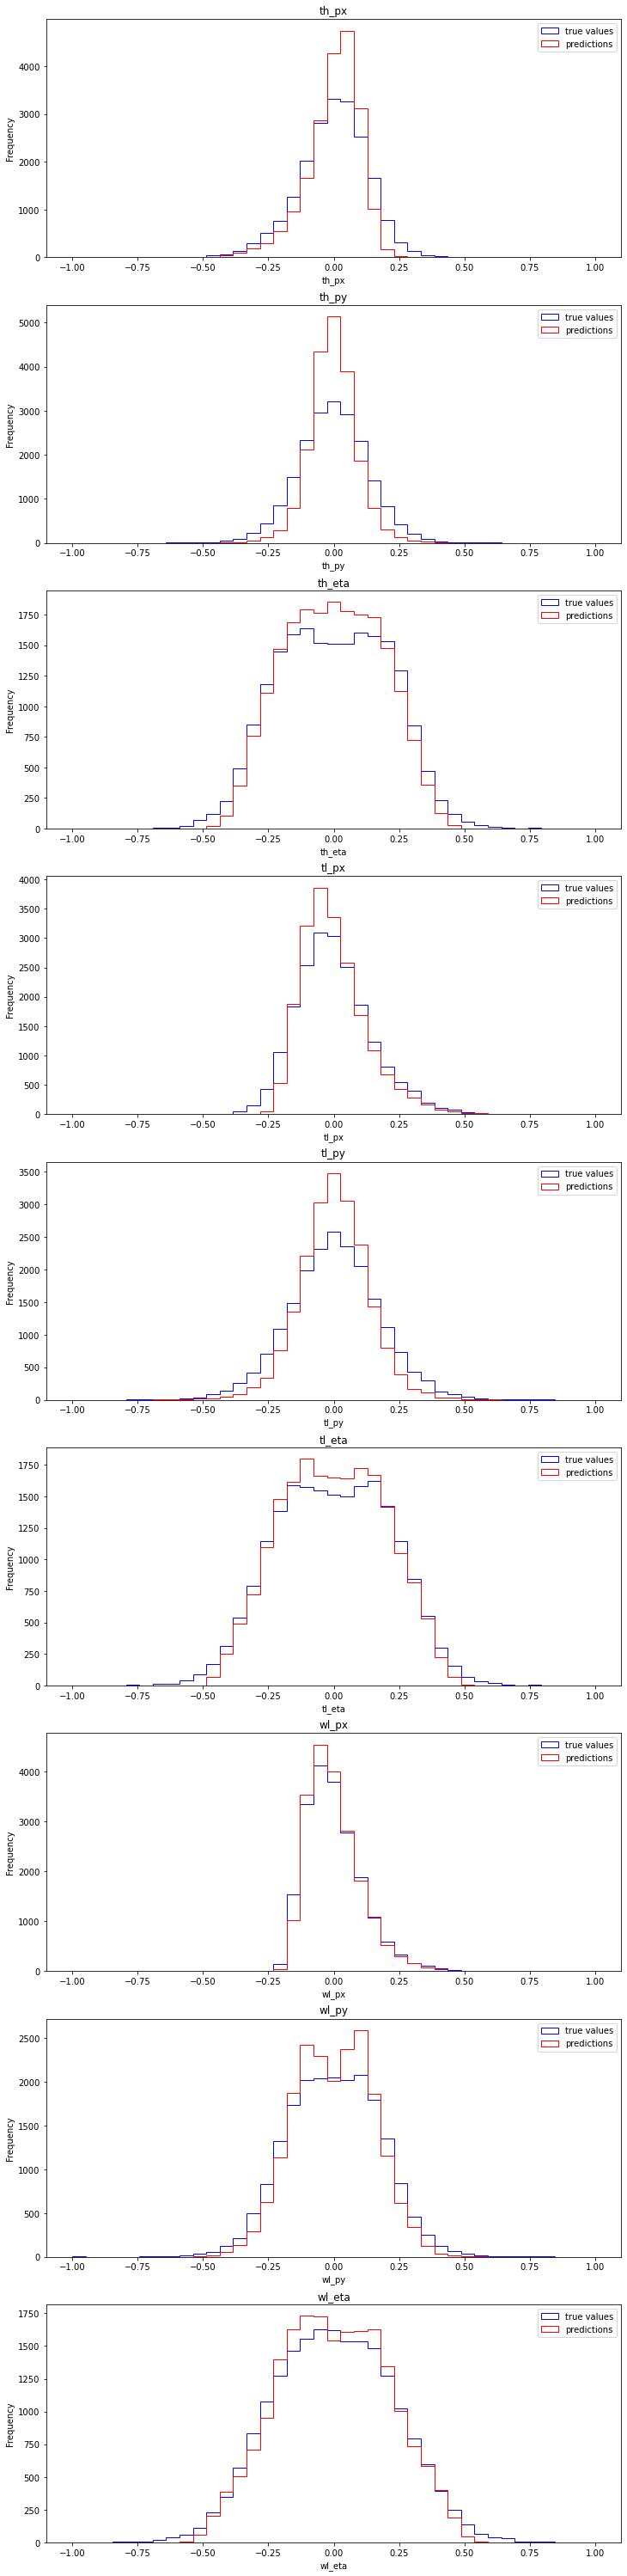

In [13]:
display.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

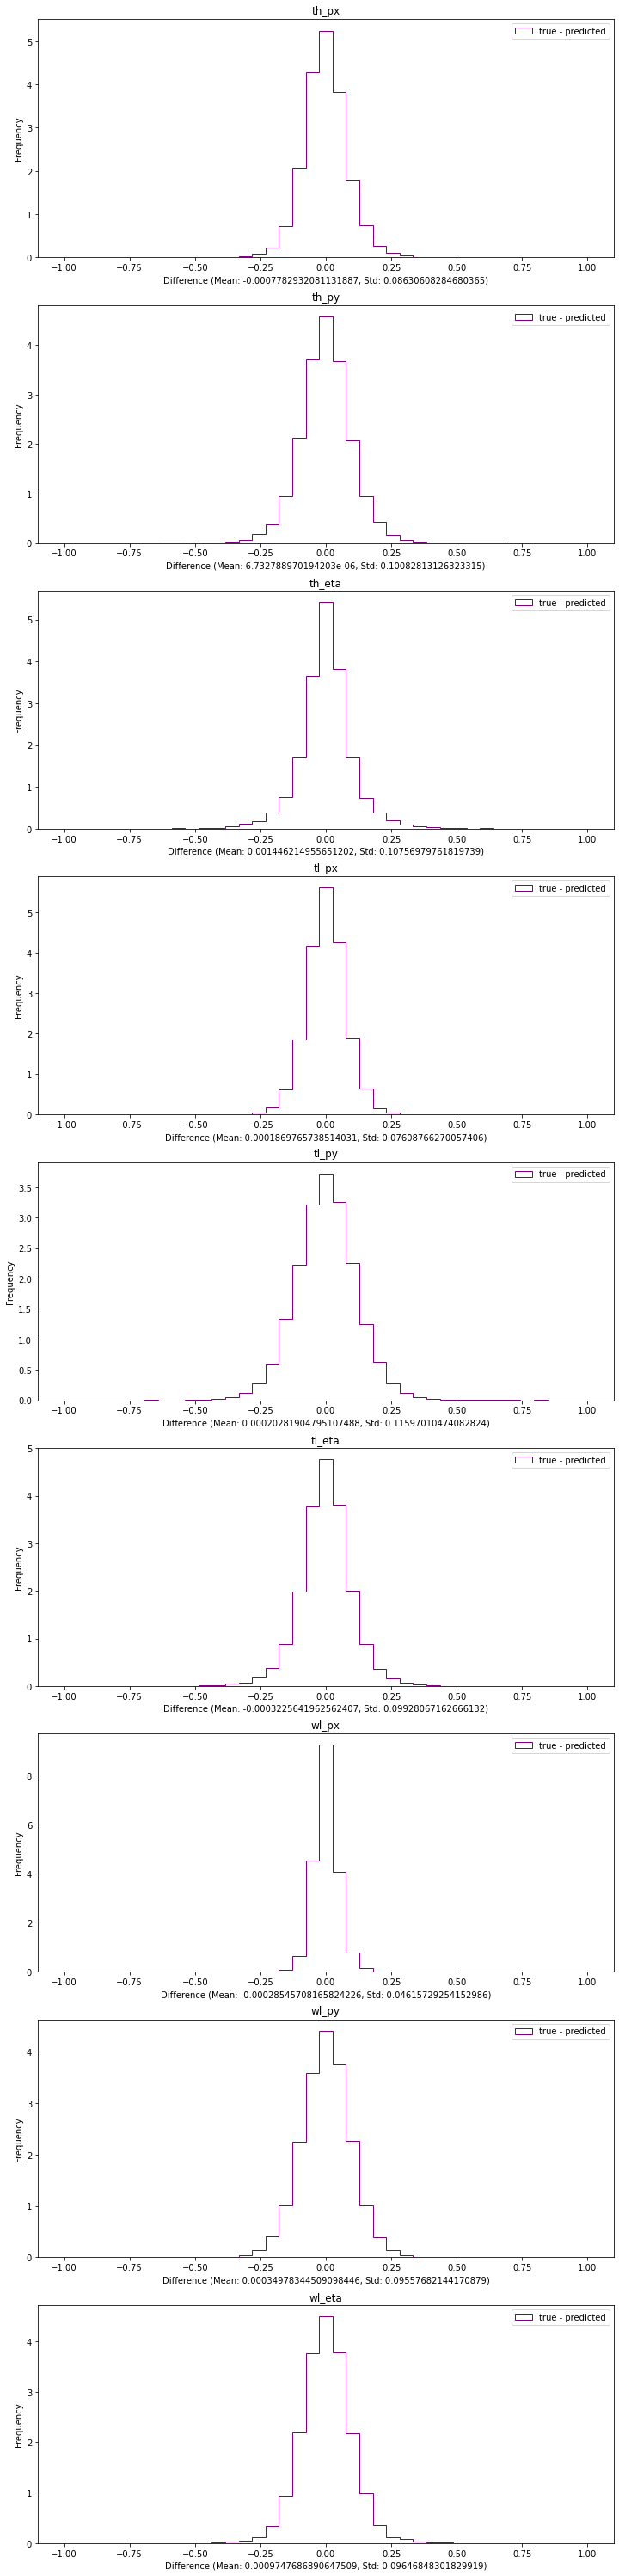

In [14]:
display.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

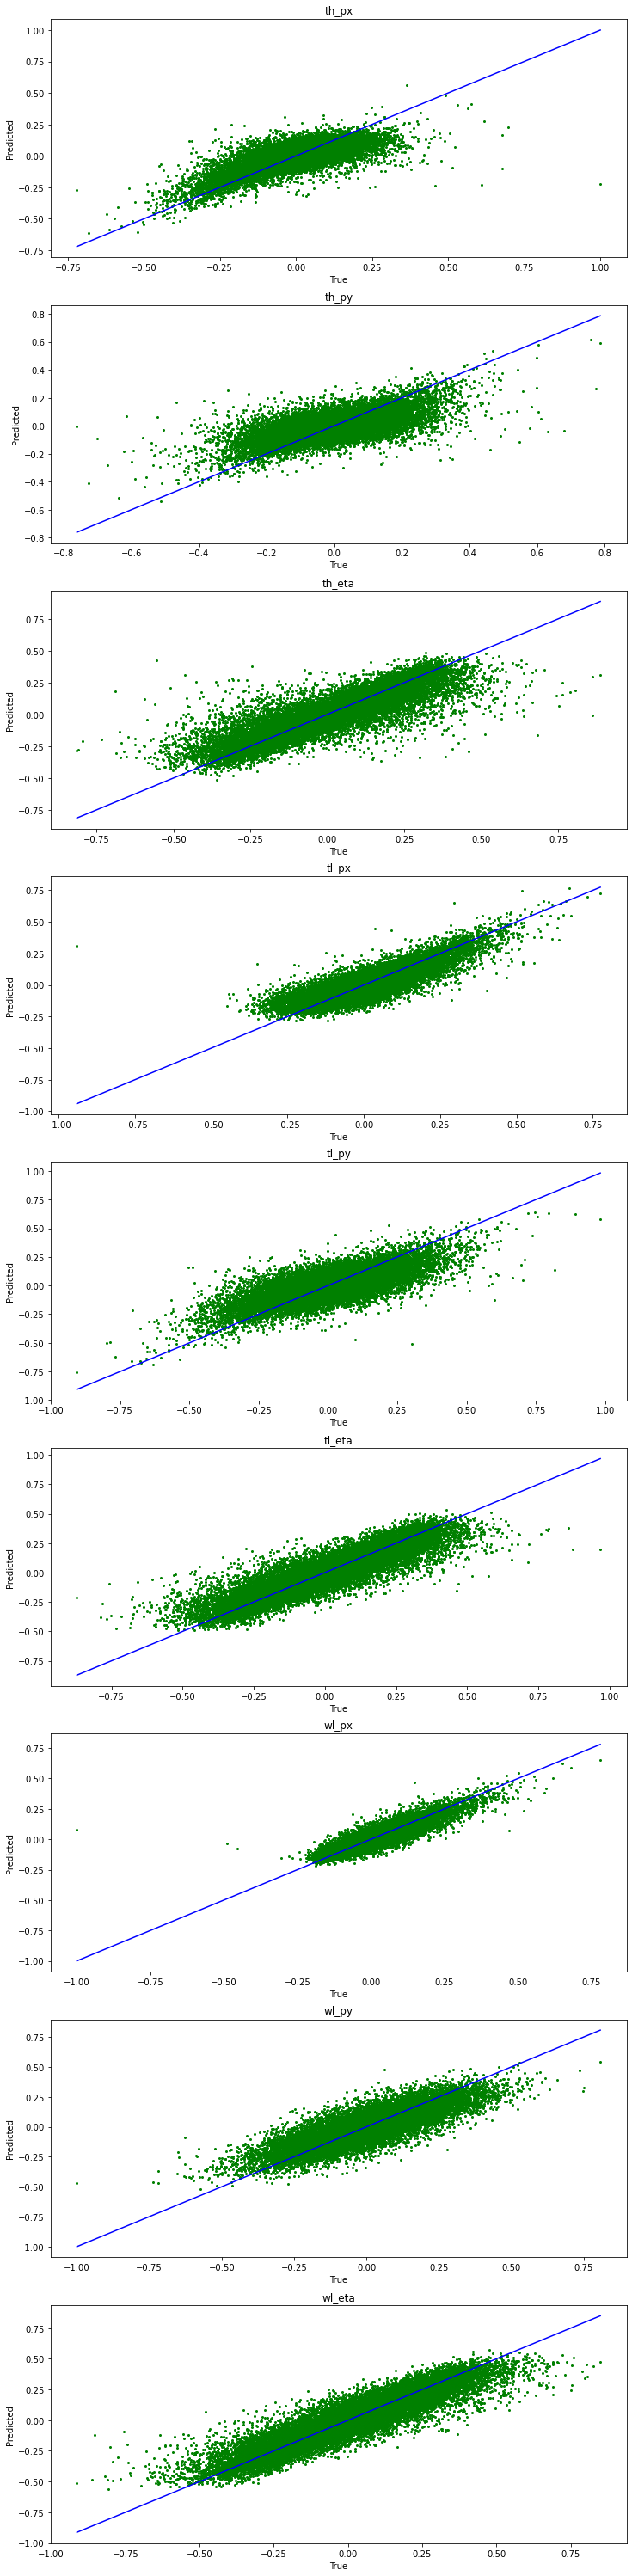

In [15]:
display.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [16]:
display.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 727.5230912145153
 
th_pt MSE :  3567.3288660677
th_eta MSE :  0.6366486139
th_phi MSE :  1.0206897240
tl_pt MSE :  2215.2689398968
tl_eta MSE :  0.4932432123
tl_phi MSE :  0.6581009159
wl_pt MSE :  756.1709302524
wl_eta MSE :  0.3326076660
wl_phi MSE :  0.2346595272


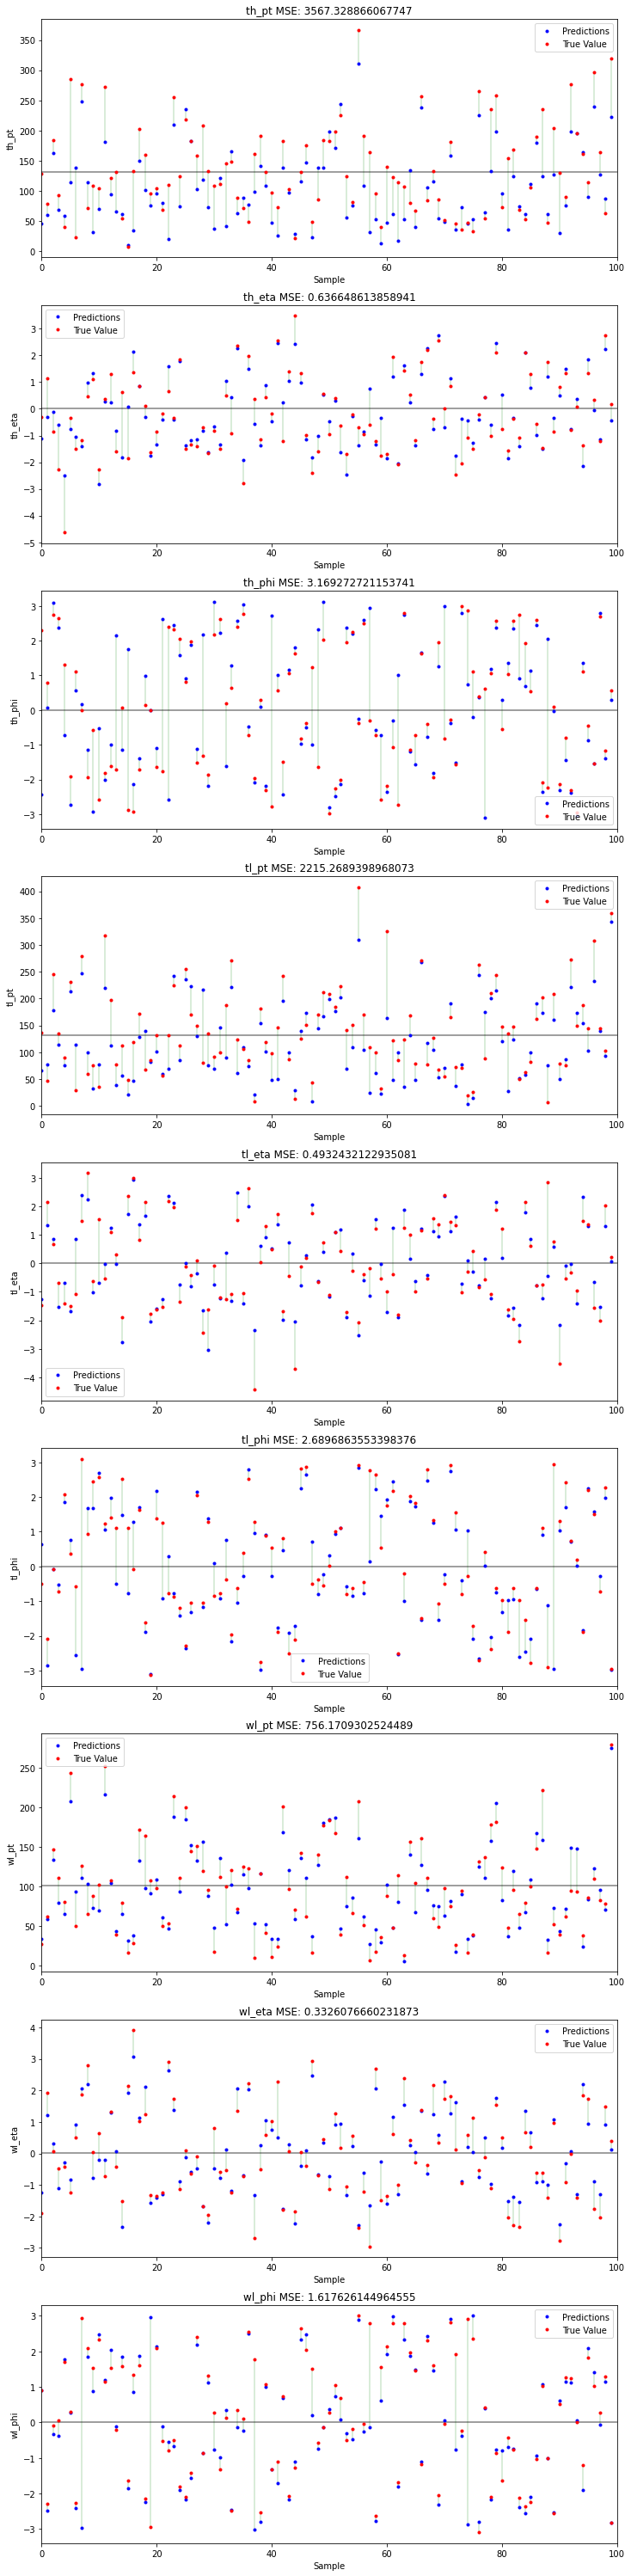

In [17]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

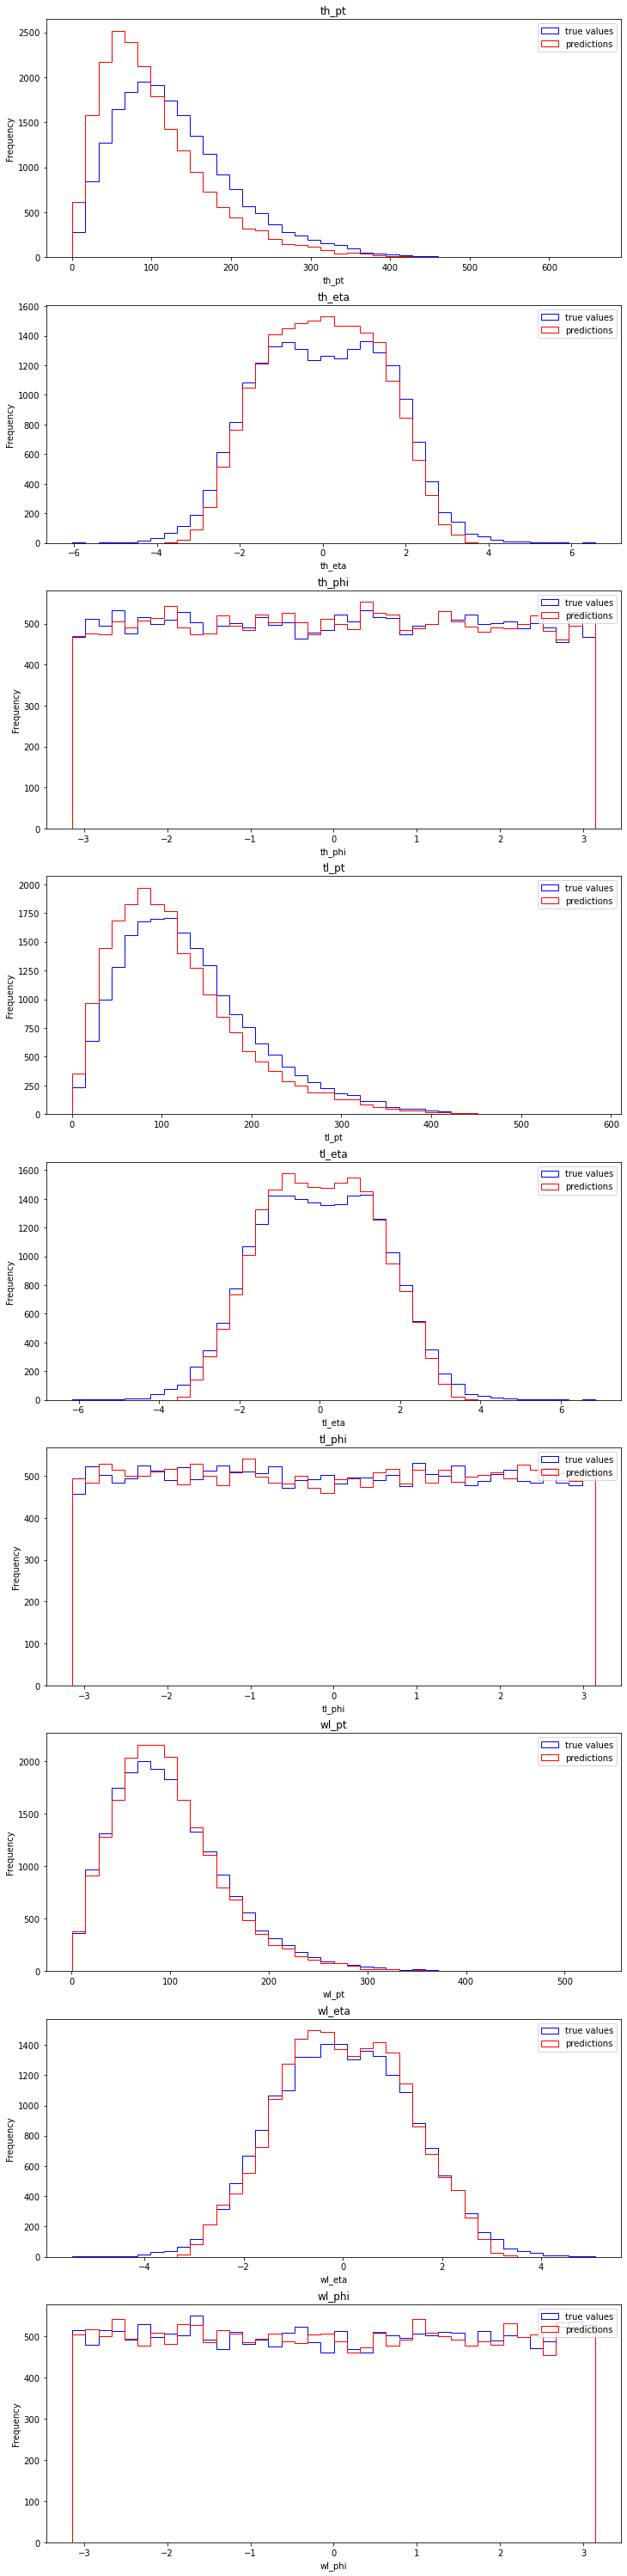

In [18]:
display.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

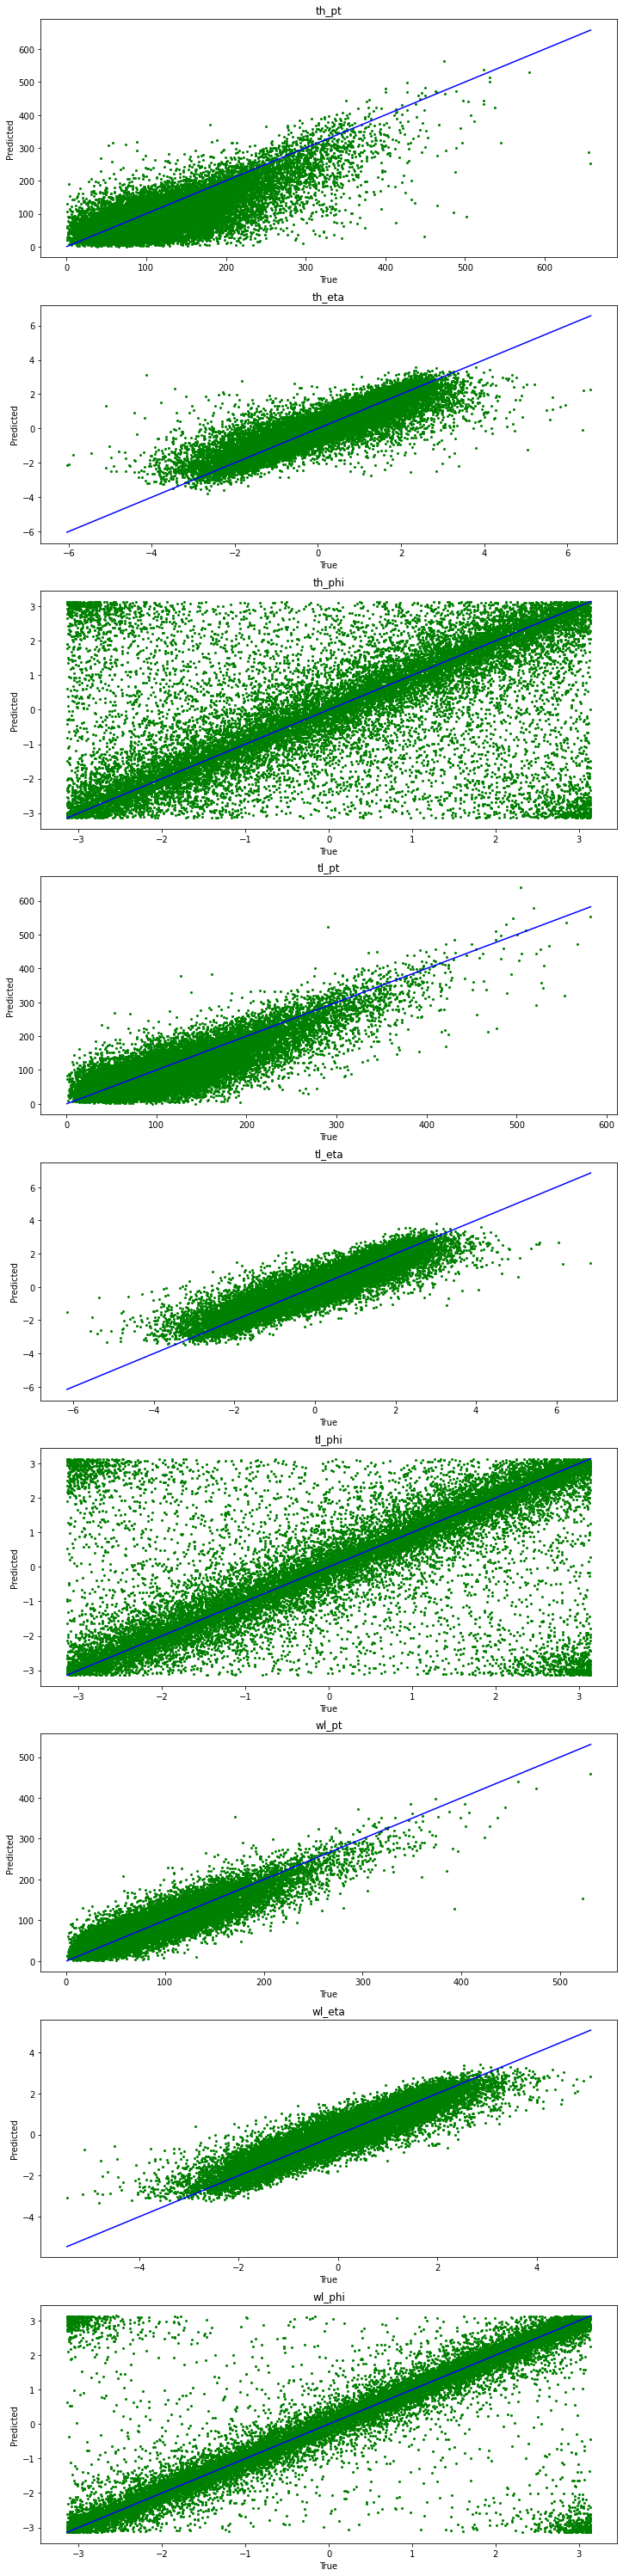

In [19]:
display.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)